In [1]:
import os
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm
import random

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
import keras
from keras import layers

/Users/ghanibhutigogoi/Documents/Federated Learning/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
print("\n--- Part 1: Loading and Consolidating Data ---")
DATA_FOLDER = 'Electricity consumption Netherlands/Electricity'
all_files = glob.glob(os.path.join(DATA_FOLDER, "*.csv"))
city_yearly_data = []

for file_path in all_files:
    filename = os.path.basename(file_path)
    parts = filename.replace('.csv', '').split('_')
    city, year = parts[0], int(parts[2])

    df_temp = pd.read_csv(file_path, low_memory=False)
    aggregated = {
        'city': city,
        'year': year,
        'total_annual_consume': df_temp['annual_consume'].sum(),
        'total_num_connections': df_temp['num_connections'].sum(),
        #'avg_smartmeter_perc': df_temp['smartmeter_perc'].mean()
    }
    city_yearly_data.append(aggregated)

master_df = pd.DataFrame(city_yearly_data)
master_df = master_df.sort_values(by=['city', 'year']).reset_index(drop=True)
print("Data consolidated into a single DataFrame:")
print(master_df.head())



--- Part 1: Loading and Consolidating Data ---
Data consolidated into a single DataFrame:
    city  year  total_annual_consume  total_num_connections
0  coteq  2013            10239701.0                52582.0
1  coteq  2014            10239701.0                52582.0
2  coteq  2015            10239701.0                52582.0
3  coteq  2016            10239701.0                52582.0
4  coteq  2017            10239701.0                52582.0



--- Part 2: Visualizing Historical Data ---
Displaying individual city consumption plots...


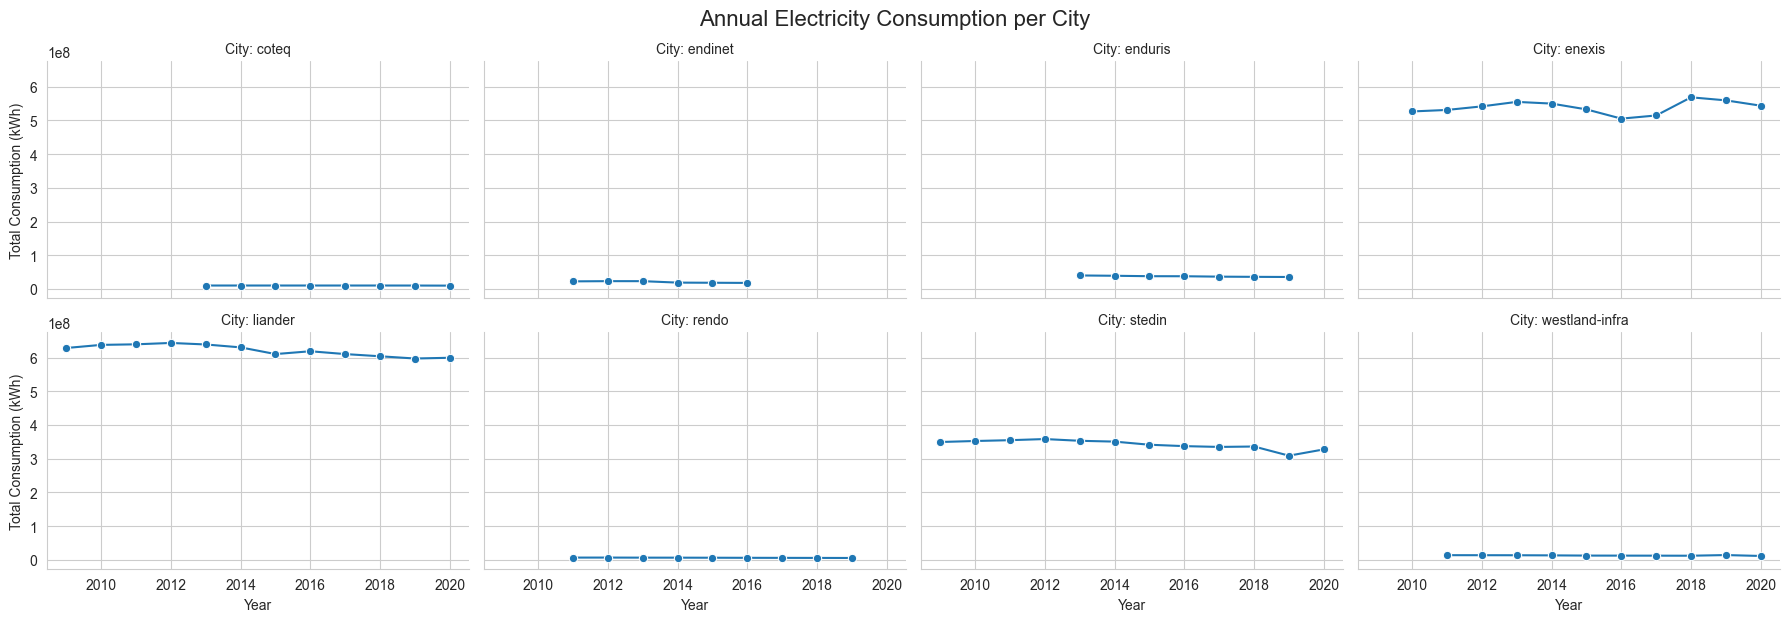

Displaying total aggregated consumption plot...


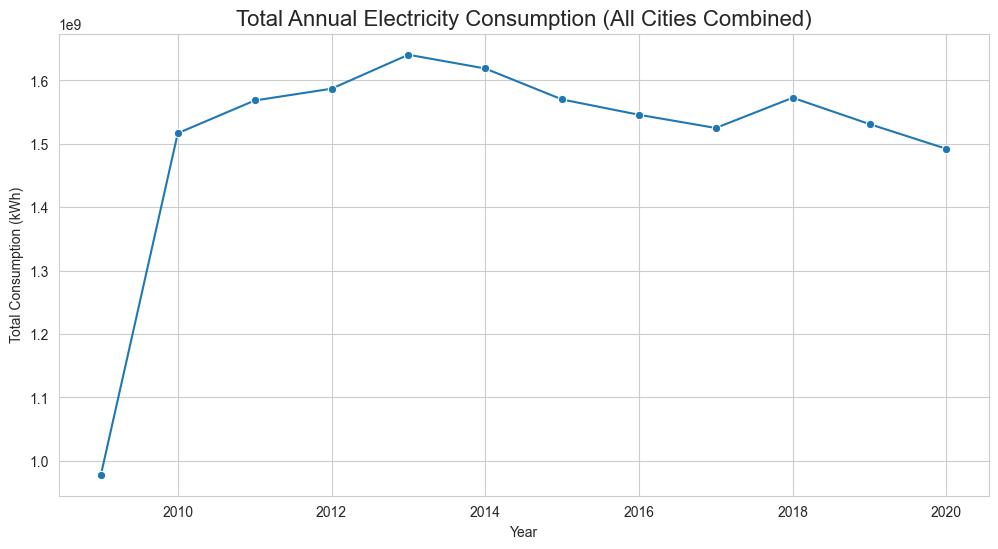

In [3]:
print("\n--- Part 2: Visualizing Historical Data ---")
sns.set_style("whitegrid")

# Plot 1: Consumption trend for each city individually
print("Displaying individual city consumption plots...")
g = sns.relplot(
    data=master_df, x='year', y='total_annual_consume',
    col='city', kind='line', col_wrap=4, height=3,
    aspect=1.5, marker='o'
)
g.fig.suptitle('Annual Electricity Consumption per City', fontsize=16, y=1.03)
g.set_titles("City: {col_name}")
g.set_axis_labels("Year", "Total Consumption (kWh)")
plt.show()

# Plot 2: Total aggregated consumption across all cities
print("Displaying total aggregated consumption plot...")
total_consumption_df = master_df.groupby('year')['total_annual_consume'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=total_consumption_df, x='year', y='total_annual_consume', marker='o')
plt.title('Total Annual Electricity Consumption (All Cities Combined)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Total Consumption (kWh)')
plt.show()



In [4]:
# Part 3: Advanced Feature Engineering & Data Processing (STRATEGY 1)
# ----------------------------------------------------------------------
print("\n--- Part 3: ADVANCED Feature Engineering for the Model ---")
df_featured = master_df.copy()

# --- Previous Features ---
df_featured['consumption_lag_1'] = df_featured.groupby('city')['total_annual_consume'].shift(1)
df_featured['consumption_lag_2'] = df_featured.groupby('city')['total_annual_consume'].shift(2)
df_featured['connections_lag_1'] = df_featured.groupby('city')['total_num_connections'].shift(1)

# --- NEW, more powerful features ---
df_featured['consumption_growth_perc'] = (df_featured['total_annual_consume'] / df_featured['consumption_lag_1']) - 1
df_featured['connections_growth_perc'] = (df_featured['total_num_connections'] / df_featured['connections_lag_1']) - 1
df_featured['year_x_connections'] = df_featured['year'] * df_featured['total_num_connections']
df_featured['year_squared'] = df_featured['year']**2

df_featured.replace([np.inf, -np.inf], 0, inplace=True)
df_featured = df_featured.dropna().reset_index(drop=True)
print("New advanced features created.")

features = ['year','total_num_connections','connections_lag_1','consumption_lag_1','consumption_lag_2','consumption_growth_perc','connections_growth_perc','year_x_connections','year_squared']
target = 'total_annual_consume'

LATEST_YEAR = df_featured['year'].max()
train_df = df_featured[df_featured['year'] < LATEST_YEAR].copy()
test_df = df_featured[df_featured['year'] == LATEST_YEAR].copy()

scaler = StandardScaler()
train_df.loc[:, features] = scaler.fit_transform(train_df[features])
test_df.loc[:, features] = scaler.transform(test_df[features])
print("All features have been scaled.")

X_train_final = np.c_[np.ones(train_df[features].values.shape[0]), train_df[features].values]
X_test_final = np.c_[np.ones(test_df[features].values.shape[0]), test_df[features].values]

# --- ADD THIS LINE TO CREATE THE Y_TRAIN ARRAY ---
y_train = train_df[target].values.reshape(-1, 1) 
# -----------------------------------------------

train_df['X_scaled_bias'] = list(X_train_final)
test_df['X_scaled_bias'] = list(X_test_final)

print("Advanced feature engineering and data preparation complete.")
print(f"Number of features is now: {len(features)}")


--- Part 3: ADVANCED Feature Engineering for the Model ---
New advanced features created.
All features have been scaled.
Advanced feature engineering and data preparation complete.
Number of features is now: 9


/var/folders/dt/738vp7mj3zggd8nnvk0jnxtc0000gn/T/ipykernel_90985/477285301.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.29488391  0.14744196  0.58976782  1.03209369  1.47441956 -1.17953565
 -0.73720978 -0.29488391  0.14744196 -0.29488391  0.14744196  0.58976782
  1.03209369  1.47441956 -1.62186152 -1.17953565 -0.73720978 -0.29488391
  0.14744196  0.58976782  1.03209369  1.47441956 -2.06418739 -1.62186152
 -1.17953565 -0.73720978 -0.29488391  0.14744196  0.58976782  1.03209369
  1.47441956 -1.17953565 -0.73720978 -0.29488391  0.14744196  0.58976782
  1.03209369  1.47441956 -2.06418739 -1.62186152 -1.17953565 -0.73720978
 -0.29488391  0.14744196  0.58976782  1.03209369  1.47441956 -1.17953565
 -0.73720978 -0.29488391  0.14744196  0.58976782  1.03209369  1.47441956]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_df.loc[:, features] = scaler.fit_transform(tra

In [5]:
print("\n--- Part 4: Defining Decentralized Ridge Regression Components ---")

# A NEW, SIMPLER AGENT using Ridge Regression
class RidgeAgent:
    def __init__(self, city_id, X_train, y_train, learning_rate=0.01, alpha=0.1):
        self.city_id = city_id
        self.X = X_train
        self.y = y_train
        self.lr = learning_rate
        self.alpha = alpha  # Regularization strength
        # Initialize weights (coefficients)
        self.w = np.zeros((X_train.shape[1], 1))

    def get_model_weights(self):
        return [self.w] # Return as a list to match the coordinator's expectation

    def set_model_weights(self, weights):
        self.w = weights[0] # Expects a list

    def local_update(self, steps=5):
        """Perform local training using gradient descent."""
        for _ in range(steps):
            # Use the entire local dataset for each step (more stable for small data)
            predictions = self.X @ self.w
            errors = predictions - self.y
            # The key difference: Ridge Regression Gradient
            # Gradient = gradient_of_MSE + gradient_of_L2_regularization
            gradient = (2/len(self.X)) * self.X.T @ errors + 2 * self.alpha * self.w
            self.w -= self.lr * gradient
        return self.get_model_weights()

# The FTQC Coordinator is IDENTICAL - it doesn't care about the model, just the weights
def ftqc_coordinator(all_agent_weights, D, Delta):
    # ... (This function is identical to the one in the TF version)
    num_agents = len(all_agent_weights)
    if num_agents == 0: return None
    consensus_weights = [np.zeros_like(w) for w in all_agent_weights[0]]
    for param_idx in range(len(consensus_weights)):
        arrays_to_average = [agent_weights[param_idx] for agent_weights in all_agent_weights]
        flat_arrays = [arr.flatten() for arr in arrays_to_average]
        num_elements = len(flat_arrays[0])
        consensus_flat = np.zeros(num_elements)
        for element_idx in range(num_elements):
            scalar_values = [fl[element_idx] for fl in flat_arrays]
            agents_state = [{'y': 2 * int(v / Delta), 'z': 2} for v in scalar_values]
            for _ in range(D):
                for i in range(num_agents):
                    if agents_state[i]['z'] > 1:
                        t = agents_state[i]['y'] // agents_state[i]['z']; agents_state[i]['y'] -= t; agents_state[i]['z'] -= 1
                        receiver = (i + 1) % num_agents
                        agents_state[receiver]['y'] += t; agents_state[receiver]['z'] += 1
            dequantized = [Delta * (s['y'] / s['z'] if s['z'] > 0 else 0) for s in agents_state]
            consensus_flat[element_idx] = np.mean(dequantized)
        consensus_weights[param_idx] = consensus_flat.reshape(arrays_to_average[0].shape)
    return consensus_weights

print("Federated Ridge Regression components defined.")



--- Part 4: Defining Decentralized Ridge Regression Components ---
Federated Ridge Regression components defined.


In [6]:
# Part 5: Hyperparameter Tuning and Final Training (STRATEGY 2)
# ------------------------------------------------------------------
print("\n--- Part 5: Hyperparameter Tuning and Decentralized Training ---")

# --- Step 5A: Define Hyperparameters to Test ---
learning_rates_to_test = [0.01, 0.005, 0.001]
alphas_to_test = [0.1, 0.01, 0.001] # Alpha (regularization) is often very sensitive
best_params = {}
best_error = float('inf')

# Define the rest of the parameters here
COMMUNICATION_ROUNDS = 150
LOCAL_STEPS = 5
D_NETWORK = 5
DELTA_QUANTIZATION = 0.01

print("Starting Hyperparameter Grid Search...")
# --- Step 5B: Grid Search Loop ---
# This loop will train and evaluate a full model for each combination.
train_df_reset = train_df.reset_index(drop=True)
y_test_numpy = test_df[target].values # Get y_test as a numpy array for evaluation

for lr in learning_rates_to_test:
    for alpha in alphas_to_test:
        print(f"\n--> Testing: Learning Rate = {lr}, Alpha = {alpha}")
        
        # Initialize agents with the current set of parameters
        temp_agents = []
        for city, local_df in train_df_reset.groupby('city'):
            indices = local_df.index.tolist()
            X_local = X_train_final[indices]
            y_local = y_train[indices] # Now this works because y_train exists
            temp_agents.append(RidgeAgent(city, X_local, y_local, learning_rate=lr, alpha=alpha))

        # Run a full training cycle for these parameters
        for _ in range(COMMUNICATION_ROUNDS): # No tqdm for cleaner logs during search
            all_local_weights = [agent.local_update(steps=LOCAL_STEPS) for agent in temp_agents]
            consensus_weights = ftqc_coordinator(all_local_weights, D=D_NETWORK, Delta=DELTA_QUANTIZATION)
            if consensus_weights:
                for agent in temp_agents:
                    agent.set_model_weights(consensus_weights)
        
        # Evaluate the resulting model on the test set
        final_weights = temp_agents[0].get_model_weights()[0]
        predictions = (X_test_final @ final_weights).flatten()
        current_error = abs(predictions.sum() - y_test_numpy.sum()) / y_test_numpy.sum() * 100
        print(f"    Resulting Error: {current_error:.2f}%")
        
        # Check if this is the best model so far
        if current_error < best_error:
            best_error = current_error
            best_params = {'learning_rate': lr, 'alpha': alpha}
            print(f"    *** New best found! ***")

print("\n--- Hyperparameter Search Complete ---")
print(f"Best parameters found: {best_params} with an error of {best_error:.2f}%")

# --- Step 5C: Final Training with Optimal Parameters ---
print("\n--- Training final model with the best parameters ---")
ridge_agents = [] # This is the final variable that the next cell (Part 6) will use
for city, local_df in train_df_reset.groupby('city'):
    indices = local_df.index.tolist()
    X_local = X_train_final[indices]
    y_local = y_train[indices]
    ridge_agents.append(RidgeAgent(city, X_local, y_local, 
                                 learning_rate=best_params['learning_rate'], 
                                 alpha=best_params['alpha']))

for _ in tqdm(range(COMMUNICATION_ROUNDS), desc="Final Federated Training"):
    all_local_weights = [agent.local_update(steps=LOCAL_STEPS) for agent in ridge_agents]
    consensus_weights = ftqc_coordinator(all_local_weights, D=D_NETWORK, Delta=DELTA_QUANTIZATION)
    if consensus_weights:
        for agent in ridge_agents:
            agent.set_model_weights(consensus_weights)
            
print("Final decentralized training complete.")


--- Part 5: Hyperparameter Tuning and Decentralized Training ---
Starting Hyperparameter Grid Search...

--> Testing: Learning Rate = 0.01, Alpha = 0.1
    Resulting Error: 10.76%
    *** New best found! ***

--> Testing: Learning Rate = 0.01, Alpha = 0.01
    Resulting Error: 0.77%
    *** New best found! ***

--> Testing: Learning Rate = 0.01, Alpha = 0.001
    Resulting Error: 0.49%
    *** New best found! ***

--> Testing: Learning Rate = 0.005, Alpha = 0.1
    Resulting Error: 8.53%

--> Testing: Learning Rate = 0.005, Alpha = 0.01
    Resulting Error: 0.12%
    *** New best found! ***

--> Testing: Learning Rate = 0.005, Alpha = 0.001
    Resulting Error: 0.79%

--> Testing: Learning Rate = 0.001, Alpha = 0.1
    Resulting Error: 7.17%

--> Testing: Learning Rate = 0.001, Alpha = 0.01
    Resulting Error: 0.74%

--> Testing: Learning Rate = 0.001, Alpha = 0.001
    Resulting Error: 1.61%

--- Hyperparameter Search Complete ---
Best parameters found: {'learning_rate': 0.005, 'alp

Final Federated Training: 100%|██████████| 150/150 [00:00<00:00, 3769.71it/s]

Final decentralized training complete.


In [7]:
# Part 6: Aggregate Forecasting and Output Visualization
# -------------------------------------------------------
print("\n--- Part 6: Evaluating and Forecasting the National Total ---")
final_weights = ridge_agents[0].get_model_weights()[0]

# --- Step 6A: Evaluate on the test year ---
X_test = np.array(test_df['X_scaled_bias'].tolist())
y_test = test_df[target].values
predictions_test_year = (X_test @ final_weights).flatten()

total_predicted = predictions_test_year.sum()
total_actual = y_test.sum()
percentage_error = abs(total_predicted - total_actual) / total_actual * 100

print(f"\nEvaluation on Test Year ({int(LATEST_YEAR)}):")
print("-" * 35)
print(f"Predicted National Total: {total_predicted:,.0f}")
print(f"Actual National Total:    {total_actual:,.0f}")
print(f"Error on National Total:  {percentage_error:.2f}%") # Should be MUCH lower now
print("-" * 35)



--- Part 6: Evaluating and Forecasting the National Total ---

Evaluation on Test Year (2020):
-----------------------------------
Predicted National Total: 1,490,170,206
Actual National Total:    1,492,001,040
Error on National Total:  0.12%
-----------------------------------



--- Part 6: Evaluating and Visualizing Historical National Performance ---

Evaluation on Test Year (2020):
-----------------------------------
Predicted National Total: 1,490,170,206
Actual National Total:    1,492,001,040
Error on National Total:  0.12%
-----------------------------------
Displaying Actual vs. Predicted national consumption plot for all years...


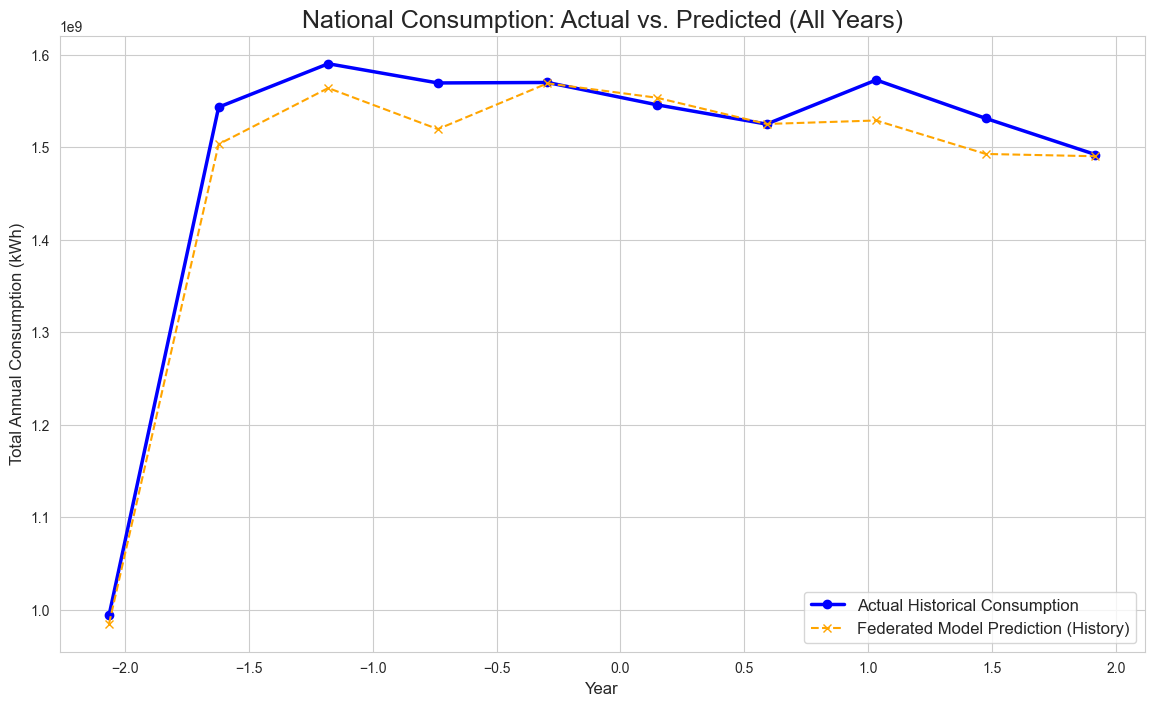

In [8]:
# Part 6: Aggregate Performance Visualization (Actual vs. Predicted Over Time)
# -------------------------------------------------------------------------------
print("\n--- Part 6: Evaluating and Visualizing Historical National Performance ---")
final_weights = ridge_agents[0].get_model_weights()[0]

# --- Step 6A: Generate Predictions for ALL Historical Data ---
# To create the comparison plot, we need predictions for both the training and test sets.
predictions_train = (X_train_final @ final_weights).flatten()
predictions_test = (X_test_final @ final_weights).flatten()

# --- Step 6B: Create a DataFrame for Cumulative Totals by Year ---
# This aligns predictions with the correct years and allows for easy aggregation.
train_df['predicted'] = predictions_train
test_df['predicted'] = predictions_test

full_results_df = pd.concat([
    train_df[['year', target, 'predicted']],
    test_df[['year', target, 'predicted']]
]).rename(columns={'total_annual_consume': 'actual'})

cumulative_results_df = full_results_df.groupby('year')[['actual', 'predicted']].sum().reset_index()


# --- Step 6C: Perform Numerical Evaluation on the Final Test Year ---
# We extract the evaluation numbers from our newly created cumulative DataFrame.
test_year_data = cumulative_results_df[cumulative_results_df['year'] == LATEST_YEAR]
if not test_year_data.empty:
    total_predicted = test_year_data['predicted'].iloc[0]
    total_actual = test_year_data['actual'].iloc[0]
    percentage_error = abs(total_predicted - total_actual) / total_actual * 100
else:
    # Fallback to your original, robust calculation if the latest year was dropped.
    total_predicted = predictions_test.sum()
    total_actual = y_test.sum()
    percentage_error = abs(total_predicted - total_actual) / total_actual * 100

print(f"\nEvaluation on Test Year ({int(LATEST_YEAR)}):")
print("-" * 35)
print(f"Predicted National Total: {total_predicted:,.0f}")
print(f"Actual National Total:    {total_actual:,.0f}")
print(f"Error on National Total:  {percentage_error:.2f}%")
print("-" * 35)


# --- Step 6D: Visualize the Historical Performance ---
print("Displaying Actual vs. Predicted national consumption plot for all years...")
plt.figure(figsize=(14, 8))

# PLOT 1: A solid blue line for the ACTUAL historical consumption.
plt.plot(cumulative_results_df['year'], cumulative_results_df['actual'], 
         label='Actual Historical Consumption', marker='o', color='blue', linewidth=2.5)

# PLOT 2: A dashed orange line for the MODEL'S PREDICTIONS on that same history.
plt.plot(cumulative_results_df['year'], cumulative_results_df['predicted'], 
         label='Federated Model Prediction (History)', marker='x', color='orange', linestyle='--')

plt.title('National Consumption: Actual vs. Predicted (All Years)', fontsize=18)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Annual Consumption (kWh)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [9]:
# Part 7: Building a Simple Model for Feature Prediction (total_num_connections)
# ------------------------------------------------------------------------------
from sklearn.linear_model import LinearRegression

print("\n--- Part 8: Building Feature Prediction Models for Each City ---")

# We'll store one simple linear model for each city in a dictionary.
connection_forecasters = {}
all_cities_for_forecast = df_featured['city'].unique()

# Iterate through each city to train a dedicated forecaster.
for city in all_cities_for_forecast:
    
    # Isolate the historical data for this city.
    city_df = df_featured[df_featured['city'] == city]
    
    # Prepare the training data for the linear model.
    # The feature X is the year, and the target y is the number of connections.
    X_train_conn = city_df[['year']]
    y_train_conn = city_df['total_num_connections']
    
    # Create and train the model.
    linear_model = LinearRegression()
    #print(X_train_conn, y_train_conn)
    linear_model.fit(X_train_conn, y_train_conn)
    
    # Store the trained model.
    connection_forecasters[city] = linear_model

print(f"Successfully trained {len(connection_forecasters)} simple forecasters for 'total_num_connections'.")

# --- Example of how a forecaster works ---
# Let's predict connections for one city for the next 5 years.
example_city = all_cities_for_forecast[0]
future_years_df = pd.DataFrame({'year': range(LATEST_YEAR + 1, LATEST_YEAR + 6)})
example_predictions = connection_forecasters[example_city].predict(future_years_df)

print(f"\nExample forecast for '{example_city}':")
for year, pred in zip(future_years_df['year'], example_predictions):
    print(f"  Year {year}: {int(pred):,} connections")


--- Part 8: Building Feature Prediction Models for Each City ---
Successfully trained 8 simple forecasters for 'total_num_connections'.

Example forecast for 'coteq':
  Year 2021: 55,491 connections
  Year 2022: 56,081 connections
  Year 2023: 56,671 connections
  Year 2024: 57,261 connections
  Year 2025: 57,851 connections



--- Part 8: Analyzing Performance using Inputs from Part 7 Models ---
Created a new, clean evaluation matrix using predicted connection counts.
Comprehensive results DataFrame (predictions based on predicted inputs):
    city  year      actual     predicted
0  coteq  2015  10239701.0  9.417249e+06
1  coteq  2016  10239701.0  1.000362e+07
2  coteq  2017  10239701.0  1.058961e+07
3  coteq  2018  10239701.0  1.117521e+07
4  coteq  2019  10179609.0  1.078687e+07

Displaying individual city time-series plots (Actual vs. Predicted)...


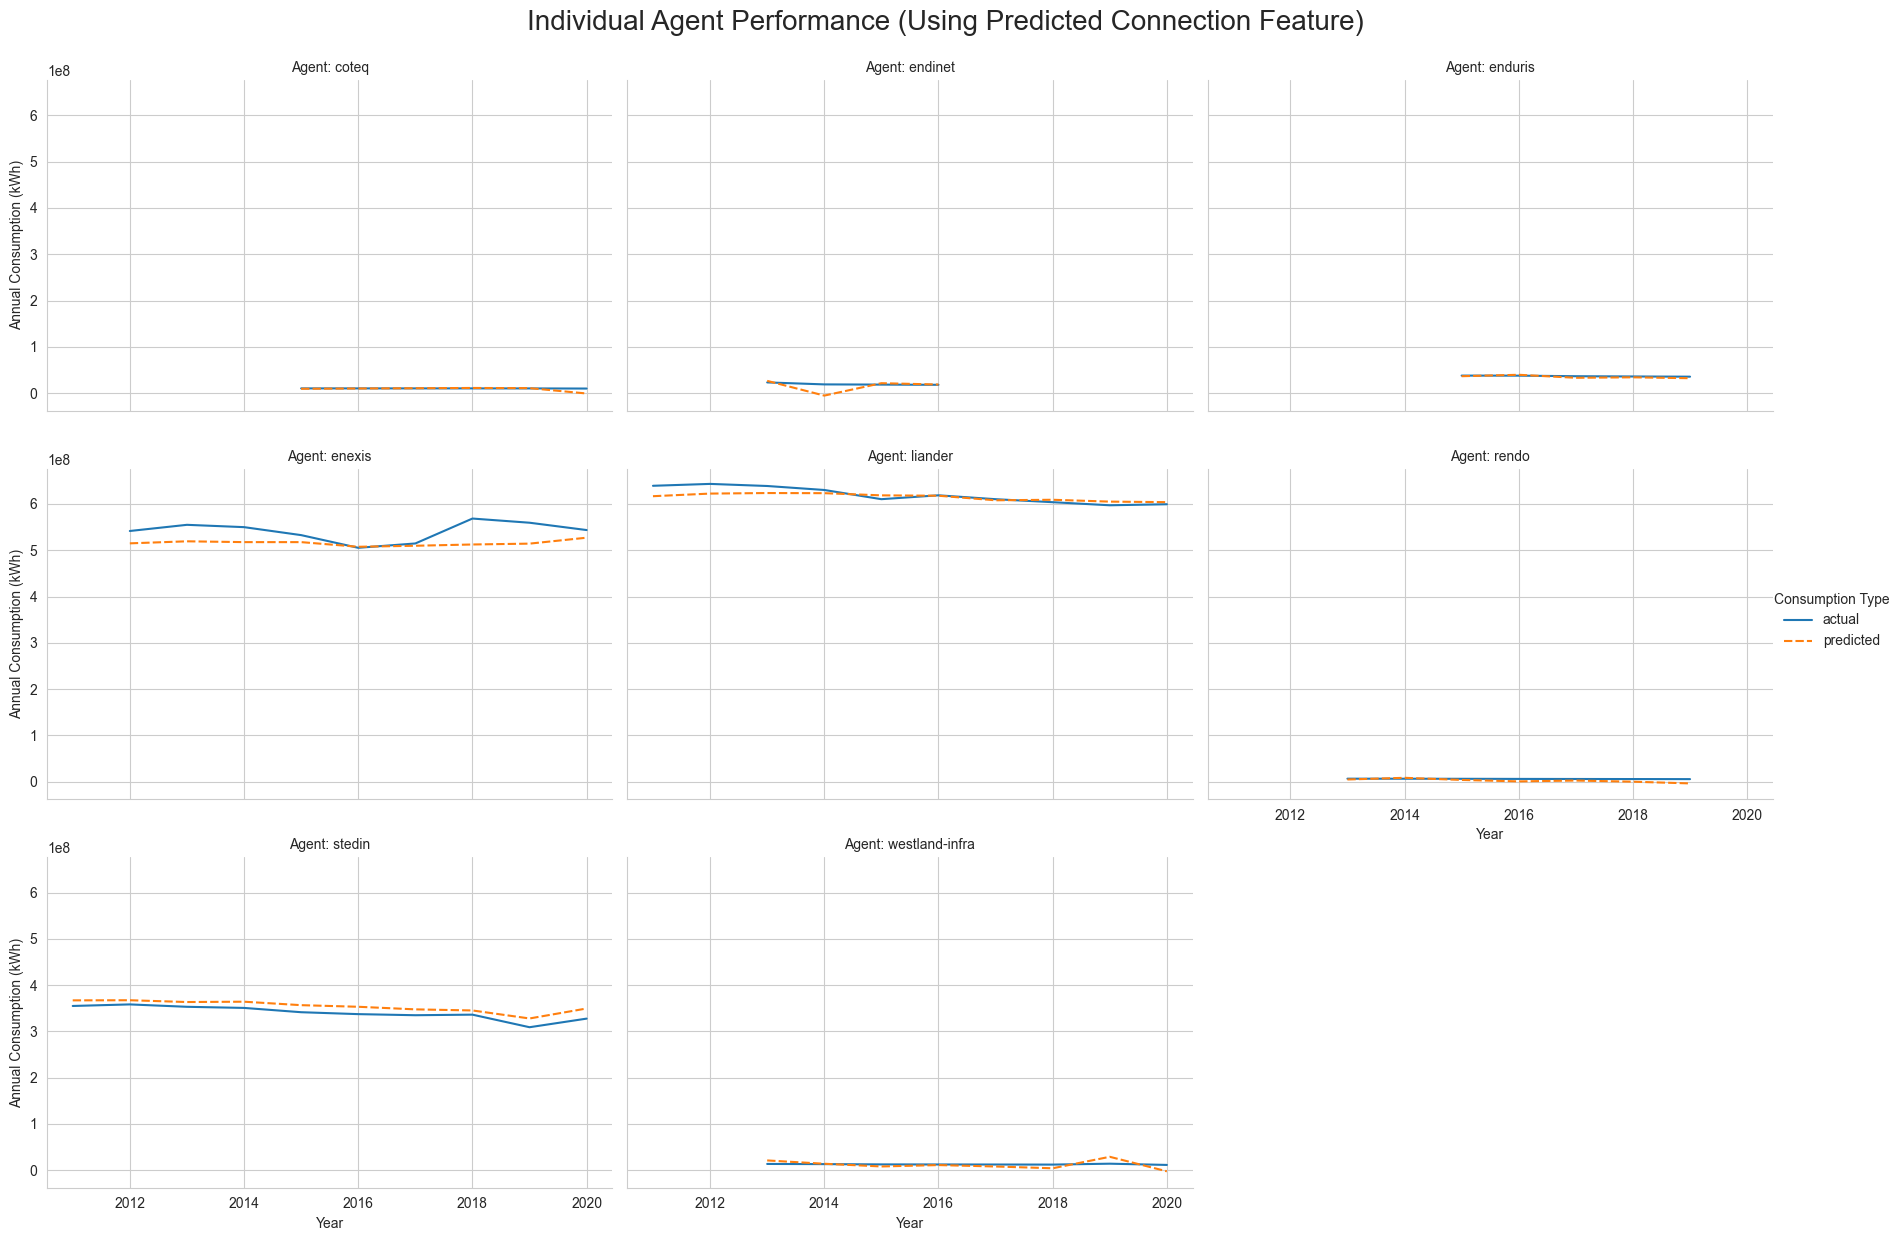

In [10]:
# Part 8: Individual Agent Performance Visualization (Using PREDICTED Connections) - FINAL
# ------------------------------------------------------------------------------------------
print("\n--- Part 8: Analyzing Performance using Inputs from Part 7 Models ---")

# --- Step 8A: Create an unscaled feature matrix using PREDICTED connections ---

# This list will hold our final feature data, row by row.
unscaled_feature_rows = []

# Iterate through the clean, feature-engineered dataframe from Part 3.
for index, original_row in df_featured.iterrows():
    city = original_row['city']
    year = original_row['year']
    
    # 1. PREDICT the 'total_num_connections' using the Part 7 model
    forecaster = connection_forecasters[city]
    predicted_connections = forecaster.predict(pd.DataFrame({'year': [year]}))[0]
    
    # 2. Get the required LAGS from the original dataframe's row
    # This ensures our lag values are correct and consistent.
    connections_lag_1 = original_row['connections_lag_1']
    
    # We must also re-calculate growth perc based on the PREDICTED connection count
    connections_growth_perc = (predicted_connections / connections_lag_1) - 1 if connections_lag_1 > 0 else 0
    
    # Build the complete feature row for our new evaluation matrix
    new_feature_row = {
        'year': year,
        'total_num_connections': predicted_connections, # Use the predicted value
        'connections_lag_1': connections_lag_1,
        'consumption_lag_1': original_row['consumption_lag_1'],
        'consumption_lag_2': original_row['consumption_lag_2'],
        'consumption_growth_perc': original_row['consumption_growth_perc'], # This is independent of connection counts
        'connections_growth_perc': connections_growth_perc,
        'year_x_connections': year * predicted_connections,
        'year_squared': original_row['year_squared']
    }
    unscaled_feature_rows.append(new_feature_row)

# Create a clean DataFrame from our list of rows.
# Crucially, we enforce the correct column order here.
X_eval_unscaled = pd.DataFrame(unscaled_feature_rows, columns=features)
X_eval_unscaled.replace([np.inf, -np.inf], 0, inplace=True)
X_eval_unscaled.fillna(0, inplace=True)

print("Created a new, clean evaluation matrix using predicted connection counts.")

# --- Step 8B: Prepare the Input Matrix for the Federated Model ---
# This is guaranteed to have the correct shape and column order.
X_eval_scaled = scaler.transform(X_eval_unscaled)
X_eval_final = np.c_[np.ones(X_eval_scaled.shape[0]), X_eval_scaled]

# --- Step 8C: Generate Predictions and Visualize ---
eval_predictions = (X_eval_final @ final_weights).flatten()

# The results_df can now be built safely.
results_df_full = df_featured[['city', 'year', target]].copy()
results_df_full['predicted'] = eval_predictions
results_df_full.rename(columns={'total_annual_consume': 'actual'}, inplace=True)

print("Comprehensive results DataFrame (predictions based on predicted inputs):")
print(results_df_full.head())

# The visualization logic is the same and will now work.
print("\nDisplaying individual city time-series plots (Actual vs. Predicted)...")
results_melted = results_df_full.melt(id_vars=['city', 'year'], value_vars=['actual', 'predicted'],
                                      var_name='type', value_name='consumption')

g = sns.relplot(
    data=results_melted, x='year', y='consumption',
    hue='type', style='type', col='city',
    kind='line', height=4, aspect=1.5, col_wrap=3
)
g.fig.suptitle('Individual Agent Performance (Using Predicted Connection Feature)', fontsize=20, y=1.03)
g.set_titles("Agent: {col_name}")
g.set_axis_labels("Year", "Annual Consumption (kWh)")
g.legend.set_title("Consumption Type")
plt.show()